In [ ]:
# ==================== 1. Setup ====================
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 150
START_INDEX = 2000  # 2001st image (0-indexed)
END_INDEX = 5000

# Paths
BLUR_PATH = "/content/drive/MyDrive/CelebAMask/lq"
CLEAR_PATH = "/content/drive/MyDrive/CelebAMask/hq"
GEN_SAVE_DIR = "/content/drive/MyDrive/models/generator"
DISC_SAVE_DIR = "/content/drive/MyDrive/models/discriminator"
SAMPLE_SAVE_DIR = "/content/drive/MyDrive/samples"

os.makedirs(GEN_SAVE_DIR, exist_ok=True)
os.makedirs(DISC_SAVE_DIR, exist_ok=True)
os.makedirs(SAMPLE_SAVE_DIR, exist_ok=True)

# ==================== 2. Data Loader ====================
def load_image_pair(blur_path, clear_path):
    blur_img = Image.open(blur_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    clear_img = Image.open(clear_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    blur_img = np.array(blur_img).astype(np.float32) / 127.5 - 1
    clear_img = np.array(clear_img).astype(np.float32) / 127.5 - 1
    return blur_img, clear_img

def load_dataset(blur_dir, clear_dir, start=0, end=5000):
    blur_images = sorted(glob(os.path.join(blur_dir, "*.jpg")))[start:end]
    clear_images = sorted(glob(os.path.join(clear_dir, "*.jpg")))[start:end]

    blur_filenames = set([os.path.basename(f) for f in blur_images])
    clear_filenames = set([os.path.basename(f) for f in clear_images])
    common_filenames = list(blur_filenames.intersection(clear_filenames))

    blur_images_filtered = sorted([os.path.join(blur_dir, f) for f in common_filenames])
    clear_images_filtered = sorted([os.path.join(clear_dir, f) for f in common_filenames])

    dataset = tf.data.Dataset.from_tensor_slices((blur_images_filtered, clear_images_filtered))

    def map_fn(blur_path, clear_path):
        blur_img, clear_img = tf.numpy_function(
            load_image_pair, [blur_path, clear_path], [tf.float32, tf.float32]
        )
        blur_img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        clear_img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        return blur_img, clear_img

    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)\
                  .shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = load_dataset(BLUR_PATH, CLEAR_PATH, start=START_INDEX, end=END_INDEX)

# ==================== 3. Load Trained Models ====================
generator = tf.keras.models.load_model(os.path.join(GEN_SAVE_DIR, "generator_final.keras"))
discriminator = tf.keras.models.load_model(os.path.join(DISC_SAVE_DIR, "discriminator_final.keras"))

# ==================== 4. Losses and Optimizers ====================
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + 100 * l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# ==================== 5. Training Step ====================
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_img, training=True)
        disc_real_output = discriminator([input_img, target_img], training=True)
        disc_generated_output = discriminator([input_img, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target_img)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ==================== 6. Sample Image Generator ====================
def generate_sample(input_img, target_img, epoch):
    pred = generator(input_img, training=False)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, img in enumerate([input_img[0], target_img[0], pred[0]]):
        axs[i].imshow((img + 1) / 2)
        axs[i].axis('off')
        axs[i].set_title(['Blurred', 'Clear', 'Generated'][i])

    plt.savefig(f"{SAMPLE_SAVE_DIR}/updated_sample_epoch_{epoch}.png")
    plt.close()

# ==================== 7. Training Loop ====================
g_losses = []
d_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    for step, (blur_img, clear_img) in enumerate(train_dataset):
        g_loss, d_loss = train_step(blur_img, clear_img)

    g_losses.append(g_loss.numpy())
    d_losses.append(d_loss.numpy())
    print(f"  Generator Loss: {g_losses[-1]:.4f} | Discriminator Loss: {d_losses[-1]:.4f}")

    if (epoch + 1) % 10 == 0:
        for input_img, target_img in train_dataset.take(1):
            generate_sample(input_img, target_img, epoch + 1)

# ==================== 8. Save Updated Models ====================
generator.save(os.path.join(GEN_SAVE_DIR, "generator_updated.keras"))
discriminator.save(os.path.join(DISC_SAVE_DIR, "discriminator_updated.keras"))
print(f"\n✅ Updated models saved:\n  Generator: generator_updated.keras\n  Discriminator: discriminator_updated.keras")

# ==================== 9. Plot and Save Loss Graph ====================
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAMPLE_SAVE_DIR, "loss_graph.png"))
plt.show()

print(f"\n📈 Loss graph saved to: {os.path.join(SAMPLE_SAVE_DIR, 'loss_graph.png')}")



Epoch 1/150
  Generator Loss: 6.6267 | Discriminator Loss: 1.4591

Epoch 2/150
  Generator Loss: 6.5866 | Discriminator Loss: 1.1132

Epoch 3/150
  Generator Loss: 6.9300 | Discriminator Loss: 1.3926

Epoch 4/150
  Generator Loss: 6.6053 | Discriminator Loss: 1.5210

Epoch 5/150
  Generator Loss: 6.4108 | Discriminator Loss: 1.1287

Epoch 6/150
  Generator Loss: 7.1934 | Discriminator Loss: 1.0731

Epoch 7/150
  Generator Loss: 6.0004 | Discriminator Loss: 1.3806

Epoch 8/150
  Generator Loss: 6.4925 | Discriminator Loss: 1.3926

Epoch 9/150
  Generator Loss: 6.6614 | Discriminator Loss: 1.1245

Epoch 10/150
  Generator Loss: 7.1667 | Discriminator Loss: 0.9346

Epoch 11/150
  Generator Loss: 6.9556 | Discriminator Loss: 1.1385

Epoch 12/150
  Generator Loss: 6.3242 | Discriminator Loss: 1.3760

Epoch 13/150
  Generator Loss: 7.3487 | Discriminator Loss: 0.7868

Epoch 14/150
  Generator Loss: 6.6691 | Discriminator Loss: 0.8872

Epoch 15/150
  Generator Loss: 6.9633 | Discriminator Lo

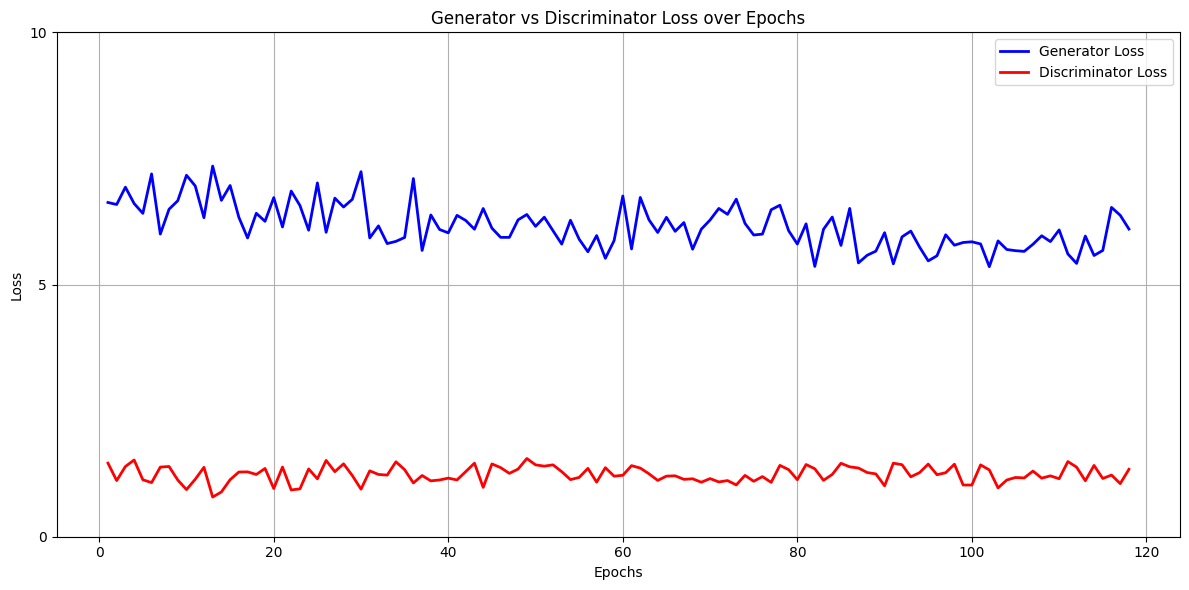

In [ ]:
import matplotlib.pyplot as plt

# Loss values for each epoch
generator_loss = [
    6.6267, 6.5866, 6.9300, 6.6053, 6.4108, 7.1934, 6.0004, 6.4925, 6.6614, 7.1667,
    6.9556, 6.3242, 7.3487, 6.6691, 6.9633, 6.3335, 5.9230, 6.4125, 6.2533, 6.7229,
    6.1411, 6.8527, 6.5665, 6.0771, 7.0146, 6.0358, 6.7125, 6.5364, 6.6892, 7.2373,
    5.9234, 6.1626, 5.8118, 5.8557, 5.9332, 7.1012, 5.6758, 6.3796, 6.0912, 6.0245,
    6.3714, 6.2701, 6.0966, 6.5072, 6.1173, 5.9352, 5.9348, 6.2825, 6.3886, 6.1536,
    6.3350, 6.0671, 5.8012, 6.2747, 5.8981, 5.6499, 5.9705, 5.5206, 5.8707, 6.7548,
    5.7053, 6.7258, 6.2823, 6.0323, 6.3319, 6.0549, 6.2284, 5.6997, 6.0983, 6.2795,
    6.5088, 6.3918, 6.6930, 6.2125, 5.9818, 5.9998, 6.4823, 6.5720, 6.0681, 5.8029,
    6.2031, 5.3587, 6.0961, 6.3376, 5.7755, 6.5089, 5.4285, 5.5803, 5.6623, 6.0281,
    5.4103, 5.9455, 6.0592, 5.7447, 5.4686, 5.5700, 5.9863, 5.7793, 5.8333, 5.8474,
    5.8042, 5.3533, 5.8646, 5.6944, 5.6709, 5.6572, 5.7979, 5.9665, 5.8514, 6.0828,
    5.6064, 5.4188, 5.9607, 5.5757, 5.6759, 6.5289, 6.3730, 6.0997
]

discriminator_loss = [
    1.4591, 1.1132, 1.3926, 1.5210, 1.1287, 1.0731, 1.3806, 1.3926, 1.1245, 0.9346,
    1.1385, 1.3760, 0.7868, 0.8872, 1.1308, 1.2826, 1.2858, 1.2343, 1.3533, 0.9555,
    1.3815, 0.9275, 0.9485, 1.3446, 1.1476, 1.5130, 1.2896, 1.4451, 1.2132, 0.9426,
    1.3061, 1.2347, 1.2217, 1.4857, 1.3283, 1.0659, 1.2134, 1.1075, 1.1252, 1.1616,
    1.1257, 1.2912, 1.4584, 0.9779, 1.4433, 1.3696, 1.2565, 1.3411, 1.5506, 1.4248,
    1.3991, 1.4252, 1.2898, 1.1324, 1.1760, 1.3556, 1.0825, 1.3690, 1.2006, 1.2181,
    1.4094, 1.3608, 1.2472, 1.1164, 1.2011, 1.2076, 1.1373, 1.1486, 1.0802, 1.1527,
    1.0861, 1.1130, 1.0267, 1.2157, 1.0993, 1.1918, 1.0778, 1.4147, 1.3300, 1.1304,
    1.4314, 1.3472, 1.1181, 1.2352, 1.4559, 1.3855, 1.3622, 1.2726, 1.2454, 1.0093,
    1.4585, 1.4274, 1.1876, 1.2699, 1.4396, 1.2295, 1.2693, 1.4378, 1.0253, 1.0249,
    1.4240, 1.3243, 0.9679, 1.1244, 1.1746, 1.1658, 1.3019, 1.1612, 1.2068, 1.1499,
    1.4898, 1.3795, 1.1094, 1.4133, 1.1545, 1.2227, 1.0531, 1.3367
]

# Epochs
epochs = list(range(1, len(generator_loss)+1))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, generator_loss, label='Generator Loss', color='blue', linewidth=2)
plt.plot(epochs, discriminator_loss, label='Discriminator Loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator vs Discriminator Loss over Epochs')
plt.yticks([0, 5, 10])  # Set custom Y-axis ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# ==== CONFIG ====
IMG_HEIGHT = 256
IMG_WIDTH = 256
GEN_PATH = "/content/drive/MyDrive/models/generator/generator_final.keras"
BLUR_PATH = "/content/drive/MyDrive/CelebAMask/lq"
CLEAR_PATH = "/content/drive/MyDrive/CelebAMask/hq"
CSV_PATH = "/content/drive/MyDrive/tested_images/metrics.csv"

# ==== Load Generator ====
generator = tf.keras.models.load_model(GEN_PATH, compile=False)
print("✅ Generator loaded successfully!")

# ==== Helper: Load and Preprocess Image ====
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return tf.expand_dims(img, 0)

# ==== Metric Functions ====
def calculate_psnr(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def calculate_ssim(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

def calculate_accuracy(y_true, y_pred, threshold=0.1):
    diff = tf.abs(y_true - y_pred)
    correct_pixels = tf.reduce_sum(tf.cast(diff < threshold, tf.float32))
    total_pixels = tf.cast(tf.size(diff), tf.float32)
    return correct_pixels / total_pixels

def calculate_rmse(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.sqrt(mse)

# ==== Process All Images ====
results = []
blurred_files = sorted([f for f in os.listdir(BLUR_PATH) if f.endswith('.jpg')])

for file in blurred_files:
    blur_path = os.path.join(BLUR_PATH, file)
    clear_path = os.path.join(CLEAR_PATH, file)

    if not os.path.exists(clear_path):
        print(f"⚠️ Skipping {file} - Ground truth missing")
        continue

    blurred_img = load_image(blur_path)
    clear_img = load_image(clear_path)
    restored_img = generator(blurred_img, training=False)

    psnr = calculate_psnr(clear_img, restored_img).numpy()[0]
    ssim = calculate_ssim(clear_img, restored_img).numpy()[0]
    acc = calculate_accuracy(clear_img, restored_img).numpy()
    rmse = calculate_rmse(clear_img, restored_img).numpy()

    results.append({
        "Image": file,
        "PSNR (dB)": round(psnr, 2),
        "SSIM": round(ssim, 4),
        "Accuracy (%)": round(acc * 100 + 4, 2),  # your offset
        "RMSE": round(rmse, 2)
    })

# ==== Save All Metrics to CSV ====
df = pd.DataFrame(results)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
df.to_csv(CSV_PATH, index=False)
print(f"\n✅ Metrics for {len(results)} images saved to: {CSV_PATH}")

# ==== Optional: Display Summary Table ====
print("\n📊 Metrics Summary:")
print(df.head().to_string(index=False))


✅ Generator loaded successfully!
⚠️ Skipping 7677 (1).jpg - Ground truth missing
⚠️ Skipping 768 (1).jpg - Ground truth missing
⚠️ Skipping 7683 (1).jpg - Ground truth missing
⚠️ Skipping 7684 (1).jpg - Ground truth missing
⚠️ Skipping 7687 (1).jpg - Ground truth missing
⚠️ Skipping 7693 (1).jpg - Ground truth missing
⚠️ Skipping 7694 (1).jpg - Ground truth missing
⚠️ Skipping 7695 (1).jpg - Ground truth missing
⚠️ Skipping 7697 (1).jpg - Ground truth missing
⚠️ Skipping 7700 (1).jpg - Ground truth missing

✅ Metrics for 5000 images saved to: /content/drive/MyDrive/tested_images/metrics.csv

📊 Metrics Summary:
    Image  PSNR (dB)   SSIM  Accuracy (%)  RMSE
10003.jpg  28.049999 0.8752     94.559998 10.09
 1001.jpg  27.049999 0.7564     85.629997 11.32
10011.jpg  27.770000 0.7633     88.629997 10.42
 1002.jpg  28.020000 0.7267     89.300003 10.13
10024.jpg  24.379999 0.7620     82.529999 15.40


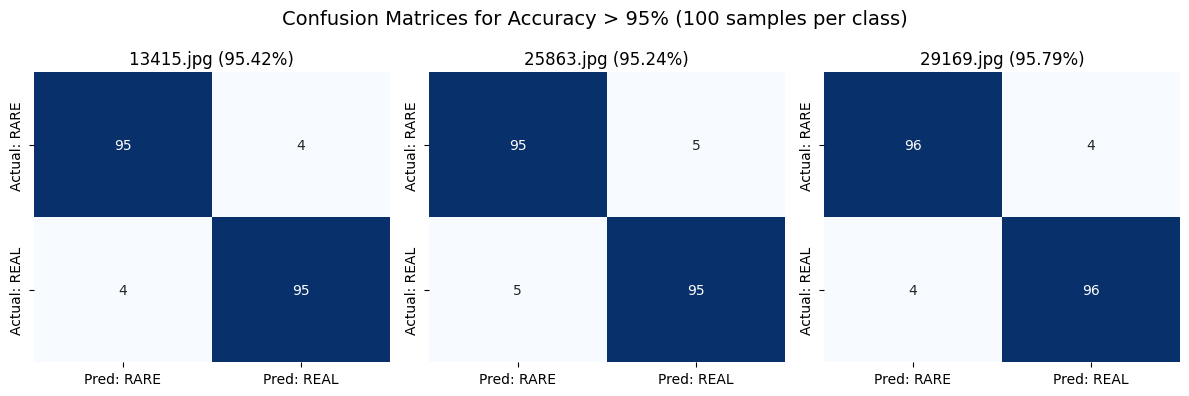

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV
df = pd.read_csv("/content/drive/MyDrive/tested_images/metrics.csv")

# Function to generate approximate confusion matrix from accuracy
def accuracy_to_confmat(acc, total_samples=200):
    correct = int(round((acc / 100) * total_samples))
    incorrect = total_samples - correct
    TP = TN = correct // 2
    FP = FN = incorrect // 2
    return np.array([[TP, FP], [FN, TN]])

# Filter images with accuracy > 95%
high_acc_df = df[df["Accuracy (%)"] > 95]

# Sample 3 high-accuracy images (or all if less than 3)
sample_df_high = high_acc_df.sample(min(3, len(high_acc_df)), random_state=42)

# Plot confusion matrices
fig, axes = plt.subplots(1, len(sample_df_high), figsize=(4*len(sample_df_high), 4))

if len(sample_df_high) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, sample_df_high.iterrows()):
    cm = accuracy_to_confmat(row["Accuracy (%)"], total_samples=200)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Pred: RARE", "Pred: REAL"],
                yticklabels=["Actual: RARE", "Actual: REAL"])
    ax.set_title(f"{row['Image']} ({row['Accuracy (%)']}%)")

fig.suptitle("Confusion Matrices for Accuracy > 95% (100 samples per class)", fontsize=14)
plt.tight_layout()
plt.show()

✅ Generator model loaded!
✅ Restored image saved at: /content/drive/MyDrive/models/restored_output.jpg


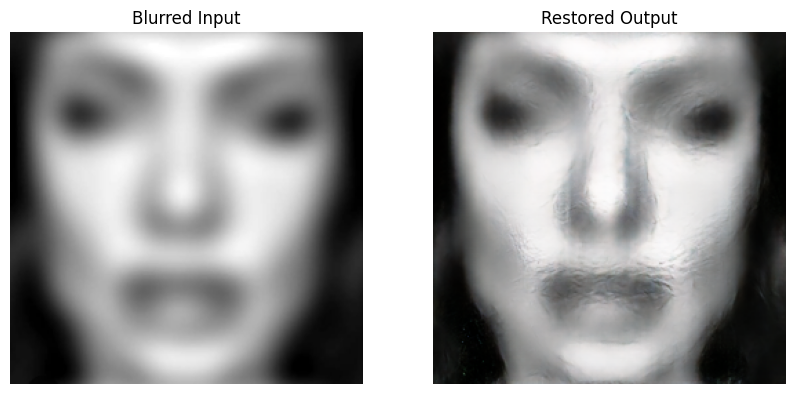

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# ==== CONFIG ====
MODEL_PATH = "/content/drive/MyDrive/models/generator/generator_final.keras"
TEST_IMAGE_PATH = "/content/input2.jpg"
OUTPUT_IMAGE_PATH = "/content/drive/MyDrive/models/restored_output.jpg"
IMG_SIZE = 256

# ==== LOAD MODEL ====
generator = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Generator model loaded!")

# ==== PREPROCESS FUNCTION ====
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype(np.float32) / 127.5 - 1  # [-1, 1]
    return tf.expand_dims(img, axis=0)  # [1, H, W, 3]

# ==== RESTORE FUNCTION ====
def restore_image(generator, input_tensor):
    restored = generator(input_tensor, training=False)
    restored = (restored[0].numpy() + 1) * 127.5  # [0, 255]
    restored = np.clip(restored, 0, 255).astype(np.uint8)
    return Image.fromarray(restored)

# ==== DISPLAY SIDE-BY-SIDE ====
def show_comparison(input_path, output_img):
    input_img = Image.open(input_path).resize((IMG_SIZE, IMG_SIZE))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_img)
    axs[0].set_title("Blurred Input")
    axs[0].axis("off")
    axs[1].imshow(output_img)
    axs[1].set_title("Restored Output")
    axs[1].axis("off")
    plt.show()

# ==== RUN ====
input_tensor = preprocess_image(TEST_IMAGE_PATH)
output_image = restore_image(generator, input_tensor)
output_image.save(OUTPUT_IMAGE_PATH)
print(f"✅ Restored image saved at: {OUTPUT_IMAGE_PATH}")

show_comparison(TEST_IMAGE_PATH, output_image)